In [1]:
#!/usr/bin/env python
# coding: utf-8

# Dataset is about bike rental service. It contains bike sharing counts aggregated on hourly basis. Total number of records: 17379 hours (2 years of rental services). There are following features:
# - instant: record index
# - dteday : date of record
# - hr : hour (0 to 23) of record
# - season : season (1:springer, 2:summer, 3:fall, 4:winter)
# - yr : year (0: 2011, 1:2012)
# - mnth : month ( 1 to 12)
# - holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
# - weekday : day of the week
# - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
# + weathersit : weather situation in the current timeframe
#     - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
#     - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#     - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#     - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
# - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
# - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
# - hum: Normalized humidity. The values are divided to 100 (max)
# - windspeed: Normalized wind speed. The values are divided to 67 (max)
# - casual: count of casual users (target 1)
# - registered: count of registered users (target 2)
# - cnt: count of total rental bikes including both casual and registered (target total)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

# Set tracking URI to MLFlow server
mlflow.set_tracking_uri("http://mlflow-server:5000")

In [2]:
df = pd.read_csv('hour.csv')

df = df.drop(columns=['instant'])

df["dteday"] =  pd.to_datetime(df["dteday"]).dt.day

# From Time column we can take only Hour value
df.rename(columns={"dteday": "day"}, inplace=True)

# dropping corelated columns
df = df.drop(columns=['season'])

# dropping values with humidity = 0
df = df[df['hum'] > 0.1]

In [3]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['casual', 'registered', 'cnt'], axis=1), #dropping target and highly correlated features
    df['cnt'],
    test_size=0.3,
    random_state=0)
print('train shape:', X_train.shape)
print('test shape:', X_test.shape)


train shape: (12148, 12)
test shape: (5207, 12)


In [4]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf =  RandomForestRegressor()
xgb = XGBRegressor()
lgb = LGBMRegressor()
        
def model_fit(parameters, x_train, x_test, Y_train, Y_test, model_name):

    # Start MLFlow run with a unique name for each model
    with mlflow.start_run(run_name=model_name):
        print(f'######-Model => {model_name}')
        model = m()

        # Grid search for best parameters
        grid = GridSearchCV(model, parameters, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')
        grid.fit(x_train, Y_train)

        # Retrain with best parameters
        model_ = m(**grid.best_params_)
        model_.fit(x_train, Y_train)

        y_pred = model_.predict(x_test)
        y_pred_train = model_.predict(x_train)

        # Log parameters and metrics
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("MAE_train", mean_absolute_error(Y_train, y_pred_train))
        mlflow.log_metric("MSE_train", mean_squared_error(Y_train, y_pred_train))
        mlflow.log_metric("RMSE_train", np.sqrt(mean_squared_error(Y_train, y_pred_train)))
        mlflow.log_metric("R2_train", r2_score(Y_train, y_pred_train))

        mlflow.log_metric("MAE_test", mean_absolute_error(Y_test, y_pred))
        mlflow.log_metric("MSE_test", mean_squared_error(Y_test, y_pred))
        mlflow.log_metric("RMSE_test", np.sqrt(mean_squared_error(Y_test, y_pred)))
        mlflow.log_metric("R2_test", r2_score(Y_test, y_pred))

        input_example = x_train[0:5]  # One sample from training set

        signature = infer_signature(x_test, y_pred)


        # Log the model
        mlflow.sklearn.log_model(model_, "model", input_example=input_example, signature=signature)

In [6]:
params_knn = dict(n_neighbors=list(range(3, 20)))

params_dt = {
           "max_depth" : [None,10,20],
           "min_samples_leaf":[1,2,4],
           "min_weight_fraction_leaf":[0.0,0.1,0.3,0.6],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[None,10,20,30,50]}

params_rf  = {
             'max_depth': [None,10,20],
             'max_features': [1, 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100, 200]}
                  
params_xgb  = {
             'max_depth': [5, 8 ,10],
             'n_estimators': [100, 300, 500],
             'learning_rate': [0.3, 0.2, 0.1],
             'min_child_weight': [1, 2],
             'subsample': [0.5, 1]}
                             
params_lgb  = {
             'max_depth': [5, 8, 10],
             'learning_rate': [0.3, 0.2, 0.1],
             'min_child_weight': [1, 2],
             'subsample': [0.5, 1]}

In [7]:
models = [KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor]
parameters = [params_knn, params_dt, params_rf, params_xgb]

In [8]:
for m, p in zip(models, parameters):
    model_name = m.__name__  # Use the model class name as the identifier
    model_fit(p, X_train_scaled, X_test_scaled, y_train, y_test, model_name)

######-Model => KNeighborsRegressor
Fitting 5 folds for each of 17 candidates, totalling 85 fits
🏃 View run KNeighborsRegressor at: http://mlflow-server:5000/#/experiments/0/runs/25ce58eac68a421283abdd46f88bf92c
🧪 View experiment at: http://mlflow-server:5000/#/experiments/0
######-Model => DecisionTreeRegressor
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
🏃 View run DecisionTreeRegressor at: http://mlflow-server:5000/#/experiments/0/runs/8a427221759b44b18f2e6cc11b587358
🧪 View experiment at: http://mlflow-server:5000/#/experiments/0
######-Model => RandomForestRegressor
Fitting 5 folds for each of 108 candidates, totalling 540 fits
🏃 View run RandomForestRegressor at: http://mlflow-server:5000/#/experiments/0/runs/3d522a2202e042dba75d7f919bd2e51b
🧪 View experiment at: http://mlflow-server:5000/#/experiments/0
######-Model => XGBRegressor
Fitting 5 folds for each of 108 candidates, totalling 540 fits
🏃 View run XGBRegressor at: http://mlflow-server:5000/#/experiments

In [9]:
best_run = mlflow.search_runs(order_by=["metrics.R2_test DESC"], max_results=1)
best_run_id = best_run.iloc[0].run_id

model_uri = f"runs:/{best_run_id}/model"
model_ = mlflow.sklearn.load_model(model_uri)
y_pred = model_.predict(X_test_scaled)


In [10]:
with mlflow.start_run(run_id=best_run_id):
    mlflow.set_tag("best_model", True)

mlflow.register_model(model_uri, "best_model")

Successfully registered model 'best_model'.
2025/03/22 03:46:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model, version 1


🏃 View run XGBRegressor at: http://mlflow-server:5000/#/experiments/0/runs/dce85b3b2a91474aa58cf26c7f11b553
🧪 View experiment at: http://mlflow-server:5000/#/experiments/0


Created version '1' of model 'best_model'.


<ModelVersion: aliases=[], creation_timestamp=1742615205765, current_stage='None', description='', last_updated_timestamp=1742615205765, name='best_model', run_id='dce85b3b2a91474aa58cf26c7f11b553', run_link='', source='/mlflow-server/artifacts/0/dce85b3b2a91474aa58cf26c7f11b553/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='1'>

🏃 View run XGBRegressor at: http://mlflow-server:5000/#/experiments/0/runs/dce85b3b2a91474aa58cf26c7f11b553
🧪 View experiment at: http://mlflow-server:5000/#/experiments/0


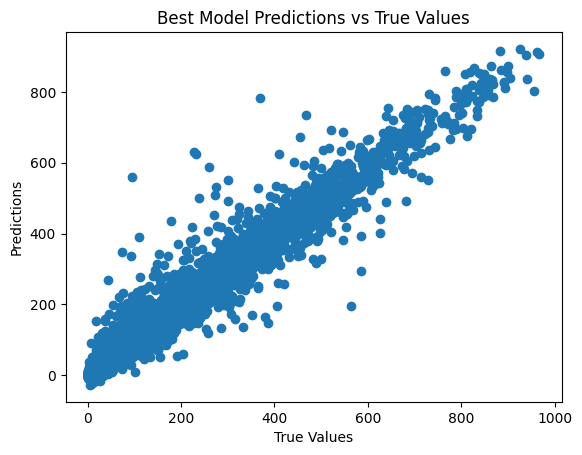

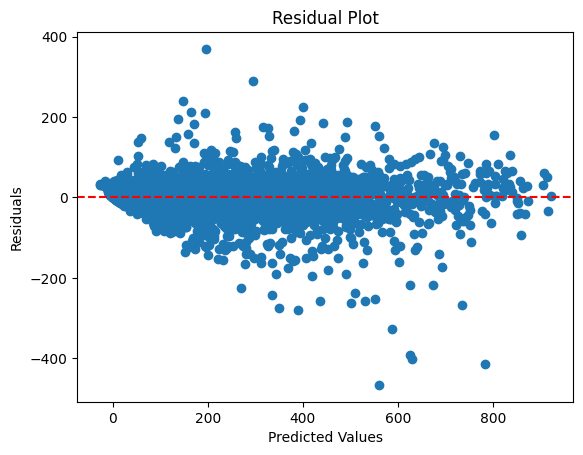

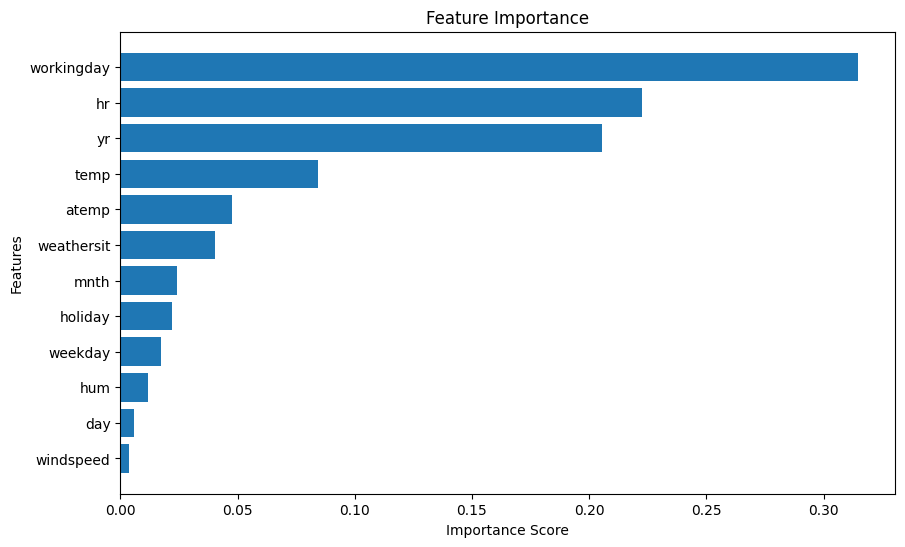

In [11]:
with mlflow.start_run(run_id=best_run_id):
    
    # Log artifacts: saving predictions and feature importances
    os.makedirs("artifacts", exist_ok=True)

    # Save predictions to a CSV file
    predictions_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    predictions_df.to_csv("artifacts/predictions.csv", index=False)
    mlflow.log_artifact("artifacts/predictions.csv")

    # Save feature names to a file
    feature_names = X_train.columns.tolist()
    with open("artifacts/features.txt", "w") as f:
        for feature in feature_names:
            f.write(f"{feature}\n")
    mlflow.log_artifact("artifacts/features.txt")

    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Best Model Predictions vs True Values")
    plt.savefig("artifacts/best_model_pred_plot.png")
    mlflow.log_artifact("artifacts/best_model_pred_plot.png")

    residuals = y_test - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.savefig("artifacts/residual_plot.png")
    mlflow.log_artifact("artifacts/residual_plot.png")

    # Log feature importance plot (for models that support it)
    if hasattr(model_, 'feature_importances_'):
        importance = model_.feature_importances_
        sorted_idx = np.argsort(importance)

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
        plt.title("Feature Importance")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.savefig("artifacts/feature_importance_plot.png")
        mlflow.log_artifact("artifacts/feature_importance_plot.png")